# **Extrapolating Sinusoidal Data using RNN**

* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**

In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# to print status reports
import sys

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

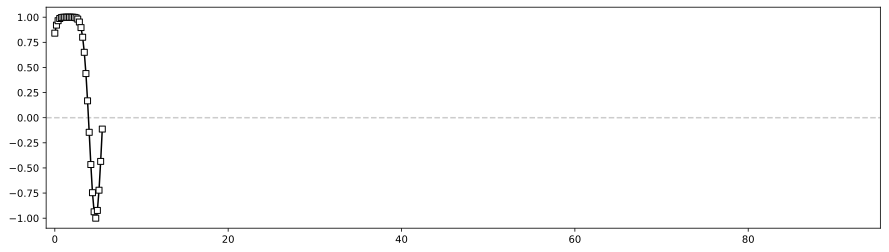

In [2]:
# create sinusoidal temporal sequence data

# import the data
points=30
len_data=int(500)
t_end=30*np.pi
t=tr.linspace(0,t_end,len_data)
data=tr.sin(t+tr.cos(t))
plt.figure(figsize=(15,4))
plt.plot([-1,t_end+1],[0,0],'--',color=[0.8,0.8,0.8])
plt.plot(t[:points],data[:points],'ks-',markerfacecolor='w')
plt.xlim([-1,t_end+1])
plt.show()

In [9]:
# create a class for DL model

class RNNnet(nn.Module):
    def __init__(self,input_size,num_hidden,num_layers):
        super().__init__()

        # RNN layer
        self.rnn=nn.RNN(input_size,num_hidden,num_layers)

        # linear layer for output
        self.out=nn.Linear(num_hidden,1)

    def forward(self,x,h):

        # run through the rnn layer
        y,hidden=self.rnn(x,h)    # no explicit hidden state initialization (default hidden state --> tr.zeros)

        # and the output layer
        y=self.out(y)
        return y,hidden.detach()   

In [10]:
# network params
input_size = 1 # "channels" of data
num_hidden = 9 # breadth of the model (no of units in the hidden layer)
num_layers = 1 # depth of the model (no of "stacks" of the hidden layer) 
seqlength  = points # number of datapoints used for learning in each segment
batchsize  = 1 # Note: the training code is actually hard-coded to organize data into batchesize=1

# create an instance of the model and inspect 
net=RNNnet(input_size,num_hidden,num_layers)

X=tr.rand(seqlength,batchsize,num_layers)
y,h=net(X,None)
print(X.shape)
print(y.shape)  # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([30, 1, 1])
torch.Size([30, 1, 1])
torch.Size([1, 1, 9])


In [11]:
# test the model with some data
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata,None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]
print(finalValue)
print(data[seqlength].view(1,1))

lossfun=nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

tensor([[0.0302]], grad_fn=<SelectBackward0>)
tensor([[0.1973]])


tensor(0.0279, grad_fn=<MseLossBackward0>)

In [12]:
# Train the model and show performance
N=len_data
lossfun=nn.MSELoss()

# number of training epochs
numepochs=30

# create a new instance of the model (and optimizer!)
net = RNNnet(input_size,num_hidden,num_layers)
optimizer=tr.optim.SGD(net.parameters(),lr=0.001)

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hiddenstate = None

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hiddenstate = net(X,hiddenstate)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())
  
  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

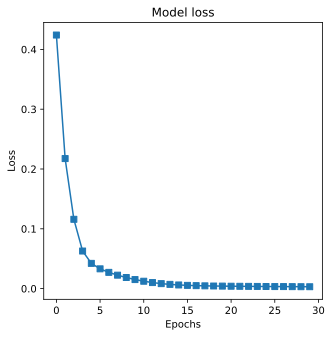

In [13]:
# let's see how did the model do?
fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.plot(losses,'s-')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Model loss")

plt.show()

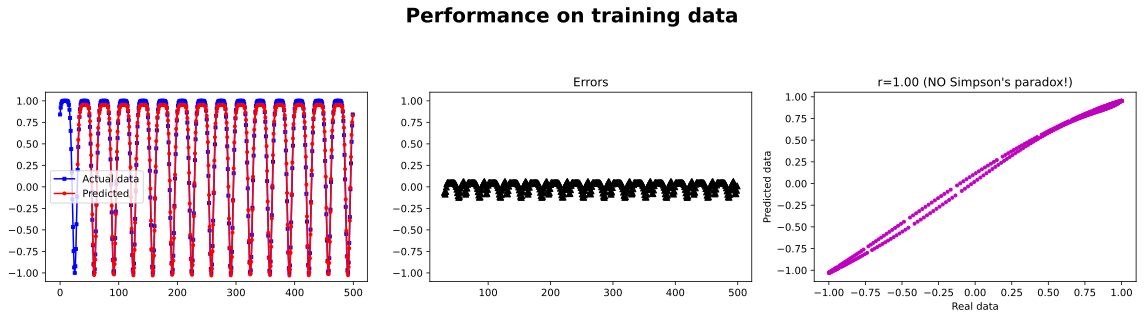

In [15]:
# now test the network

# initialize hidden state
h=np.zeros((N,num_hidden))

# initialize predicted values
yHat=np.zeros(N)
yHat[:]=np.nan
# loop over time segments
for timei in range(N-seqlength):
    # grab a snippet of data
    X=data[timei:timei+seqlength].view(seqlength,1,1)

    # forward pass and loss 
    yy,hh=net(X,None)
    yHat[timei+seqlength]=yy[-1]
    h[timei+seqlength,:]=hh.detach()



## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

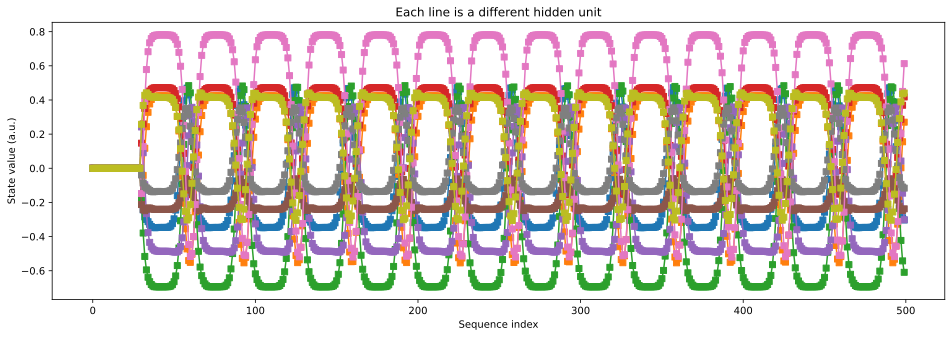

In [16]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

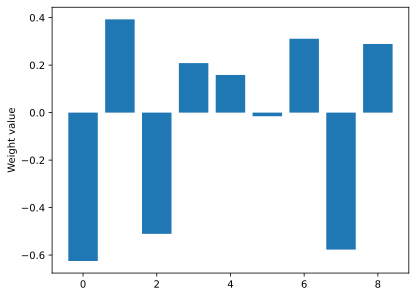

In [17]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach().squeeze())
plt.ylabel('Weight value')
plt.show()

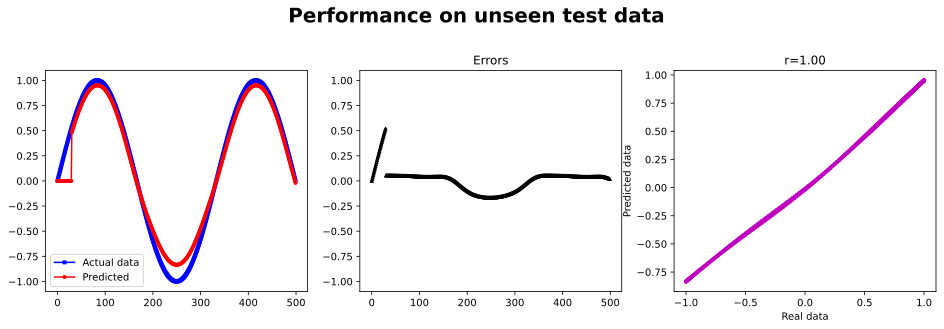

In [19]:
## Create new data (different duration)
# time = tr.linspace(0,10*np.pi,N)
# newdata = tr.sin(time+tr.cos(time))

# Create new data (different function)
time = tr.linspace(0,30*np.pi,N)
newdata = tr.sin(time/10)
# newdata = tr.sin(time+tr.sin(time))



# loop over time and predict each subsequent value
yHat = np.zeros(N)
h = None
for timei in range(N-seqlength):

  # grab a snippet of data
  X = newdata[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss (don't need hidden states here)
  yy,h = net(X,None)
  yHat[timei+seqlength] = yy[-1]


# plotting
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^',markersize=3)
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

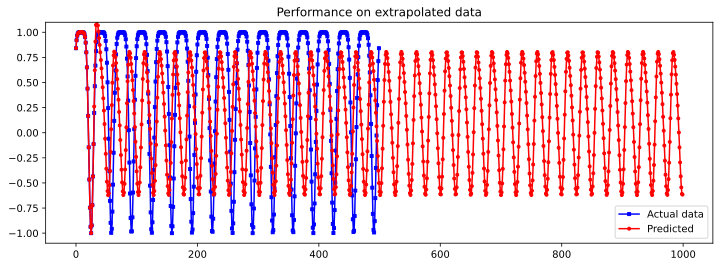

In [21]:
# using original data

# create a signal 2x as long
yHat = tr.zeros(2*N) # torch, not np!
yHat[:N] = data
h = None

for timei in range(2*N-seqlength):

  # grab a snippet of data
  X = yHat[timei:timei+seqlength].view(seqlength,1,1)
  
  # forward pass and loss
  yy,h = net(X,None)
  yHat[timei+seqlength] = yy[-1]



# convert back to np for plotting
yHat = yHat.detach()

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(data,'bs-',label='Actual data',markersize=3)
plt.plot(yHat,'ro-',label='Predicted',markersize=3)
plt.ylim([-1.1,1.1])
plt.legend()
plt.title('Performance on extrapolated data')
plt.show()

In [ ]:
# 1) Extrapolation was awful! Maybe the model is too simple? Try increasing the sequence length and the number of hidden units. Does that help the extrapolation?